In [ ]:
pip install --upgrade sympy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cud

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 887kB/s]


/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


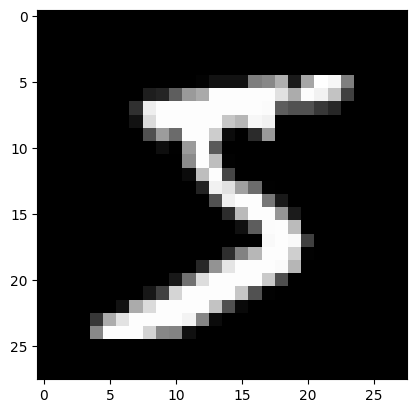

In [2]:
numpy_img = trainloader.dataset.train_data[0].numpy()
plt.imshow(numpy_img, cmap="gray");

In [26]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
latent_dim = 10

class VAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(VAE, self).__init__()

        # Кодировщик
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim*2)
        )

        # Декодировщик
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Кодирование
        x = self.encoder(x)
        mu, log_var = x[:, :latent_dim], x[:, latent_dim:]
        z = self.reparameterize(mu, log_var)

        # Декодирование
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var
    def sample(self, num_samples):
        z = torch.randn((num_samples, latent_dim)).to(device)  # Создаем случайные латентные векторы
        generated_images = self.decoder(z)
        return generated_images

In [27]:
def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

def bce(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + bce(x, reconstruction)


In [28]:
from tqdm.notebook import tqdm
autoencoder = VAE(latent_dim).to(device)
optimizer = optim.Adam(autoencoder.parameters())

# Обучение
n_epochs = 15
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in trainloader:
        optimizer.zero_grad()
        data = batch[0].to(device)

        reconstruction, mu, log_var = autoencoder(data)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        loss = loss_vae(data, mu, log_var, reconstruction)
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in testloader:
            data = batch[0].to(device)
            reconstruction, mu, log_var = autoencoder(data)

            reconstruction = reconstruction.view(-1, 1, 28, 28)

            loss = loss_vae(data, mu, log_var, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 21125.60525428105, Val Loss: 15203.270821486847
Epoch 2/15, Train Loss: 14748.240965235207, Val Loss: 14007.895912653283
Epoch 3/15, Train Loss: 14062.357600946161, Val Loss: 13627.306744152987
Epoch 4/15, Train Loss: 13745.681542760527, Val Loss: 13413.86126322686
Epoch 5/15, Train Loss: 13546.100485990804, Val Loss: 13280.249182592464
Epoch 6/15, Train Loss: 13395.006092583955, Val Loss: 13189.737055911293
Epoch 7/15, Train Loss: 13289.581029700827, Val Loss: 13090.759719269185
Epoch 8/15, Train Loss: 13191.735616004797, Val Loss: 13025.123853466179
Epoch 9/15, Train Loss: 13116.148343799974, Val Loss: 13002.9865537233
Epoch 10/15, Train Loss: 13049.973245519057, Val Loss: 12902.840716784513
Epoch 11/15, Train Loss: 12994.873221781716, Val Loss: 12952.881063340585
Epoch 12/15, Train Loss: 12945.734933035714, Val Loss: 12805.02220289013
Epoch 13/15, Train Loss: 12897.682746285314, Val Loss: 12813.850363429588
Epoch 14/15, Train Loss: 12855.652535314499, Val Los

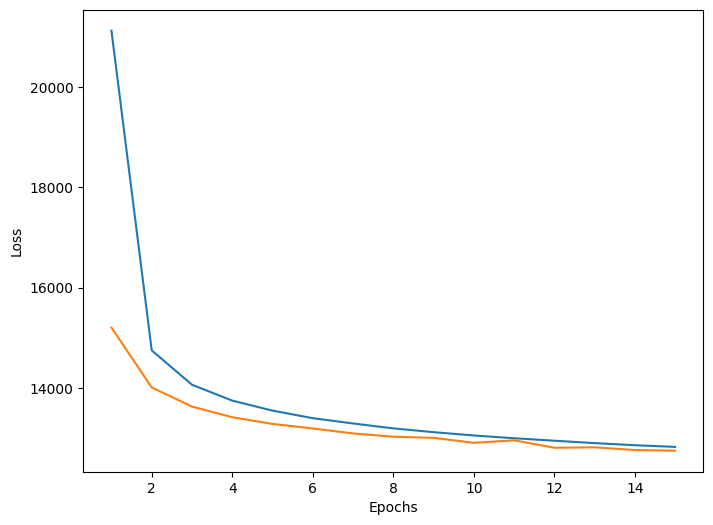

In [29]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(8,6))
plt.plot(epochs, train_losses,label='Train Loss')
plt.plot(epochs,val_losses,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

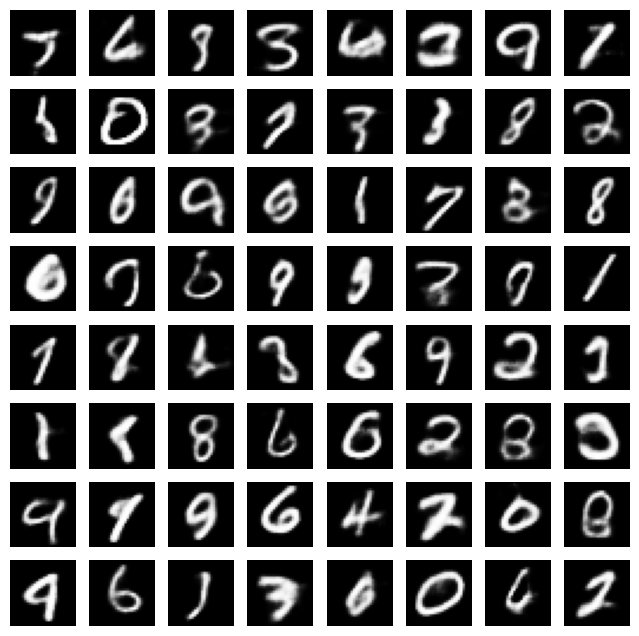

In [30]:
with torch.no_grad():
    num_samples = 64
    generated_images = autoencoder.sample(num_samples)

    generated_images = generated_images.cpu().numpy()

    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(generated_images[i*8 + j].reshape(28, 28), cmap="gray")
            axes[i, j].axis("off")
    plt.show()


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.linalg import sqrtm

# Определяем LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, return_features=False):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)  # Разворачиваем в вектор

        features = F.relu(self.fc1(x))
        if return_features:
            return features

        x = F.relu(self.fc2(features))
        x = self.fc3(x)
        return x


lenet = LeNet().to(device)
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Обучаем LeNet на MNIST
n_epochs = 5
lenet.train()
for epoch in range(n_epochs):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

# Переключаем в eval mode
lenet.eval()


Epoch 1/5, Loss: 0.11001786589622498
Epoch 2/5, Loss: 0.12015614658594131
Epoch 3/5, Loss: 0.00847670342773199
Epoch 4/5, Loss: 0.0365484319627285
Epoch 5/5, Loss: 0.15301069617271423


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
def get_features(images, model):
    with torch.no_grad():
        features = model(images, return_features=True)
    return features

def calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen):
    """
    FID = ||mu_real - mu_gen||^2 + Tr(sigma_real + sigma_gen - 2 * sqrt(sigma_real * sigma_gen))
    """
    diff = torch.norm(mu_real - mu_gen) ** 2
    covmean = sqrtm((sigma_real @ sigma_gen).cpu().numpy())
    if np.iscomplexobj(covmean):  # На случай числовых ошибок
        covmean = covmean.real
    covmean = torch.tensor(covmean, dtype=torch.float32, device=device)

    return diff + torch.trace(sigma_real + sigma_gen - 2 * covmean)


In [33]:
# Получаем фичи для реальных изображений
real_images = next(iter(trainloader))[0].to(device)
real_features = get_features(real_images, lenet)
mu_real, sigma_real = real_features.mean(dim=0), torch.cov(real_features.T)

# Получаем фичи для сгенерированных изображений
generated_images = autoencoder.sample(128).to(device)
gen_features = get_features(generated_images, lenet)
mu_gen, sigma_gen = gen_features.mean(dim=0), torch.cov(gen_features.T)

# Вычисляем FID
fid_value = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print(f"FID (на LeNet): {fid_value.item()}")


FID (на LeNet): 59.226844787597656


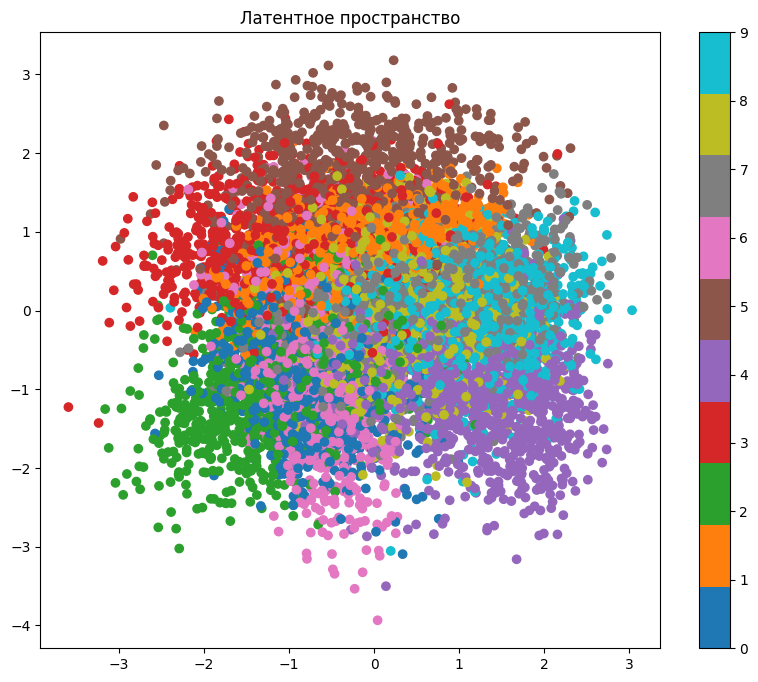

In [11]:
from sklearn.decomposition import PCA
with torch.no_grad():
    all_latents = []
    all_labels = []
    for batch in testloader:
        data, labels = batch
        data = data.to(device)
        reconstruction, mu, log_var = autoencoder(data)
        all_latents.append(mu.cpu().numpy())  # mu — это латентные представления
        all_labels.append(labels.numpy())

    # Объединяем все латентные представления
    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Применяем PCA для уменьшения размерности
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(all_latents)

    # Визуализируем латентное пространство
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=all_labels, cmap="tab10")
    plt.colorbar()
    plt.title("Латентное пространство")
    plt.show()


In [12]:
# Note: 'keras<3.x' or 'tf_keras' must be installed (legacy)
# See https://github.com/keras-team/tf-keras for more details.
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("Maksimk04/Digits_autoencoder_mnist")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

keras_metadata.pb:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/275k [00:00<?, ?B/s]

NN.png:   0%|          | 0.00/44.4k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/3.00M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

image.png:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

(…)F%D1%80%D0%BE%D0%B2%D0%BE%D0%B9_47.ipynb:   0%|          | 0.00/80.1k [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/3.15k [00:00<?, ?B/s]

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 3)                 124233    
                                                                 
 decoder (Functional)        (None, 784)               125014    
                                                                 
Total params: 249247 (973.62 KB)
Trainable params: 249247 (973.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


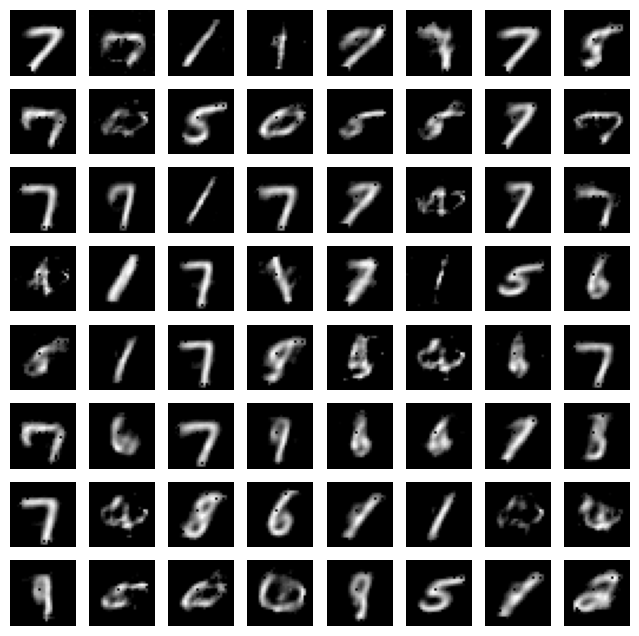

In [14]:
import tensorflow as tf

latent_vectors = np.random.randn(64, 784)

# Преобразуем латентные векторы в тензоры TensorFlow
latent_vectors = tf.convert_to_tensor(latent_vectors, dtype=tf.float32)

# Используем модель для декодирования латентных векторов
generated_images = model(latent_vectors)

# Преобразуем изображения для отображения
generated_images = generated_images.numpy()

# Создаем фигуру для отображения 64 изображений
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(generated_images[i*8 + j].reshape(28, 28), cmap="gray")
        axes[i, j].axis("off")
plt.show()

In [15]:
real_images = next(iter(trainloader))[0].to(device)

# Получаем признаки реальных изображений
real_features = get_features(real_images, lenet)
mu_real, sigma_real = real_features.mean(dim=0), torch.cov(real_features.T)

# Генерация изображений через TensorFlow модель
latent_vectors = np.random.randn(128, 784).astype(np.float32)
latent_vectors = tf.convert_to_tensor(latent_vectors)

generated_images = model(latent_vectors).numpy()

# Преобразуем в формат PyTorch `[batch, 1, 28, 28]`
generated_images = torch.tensor(generated_images).view(-1, 1, 28, 28).to(device)

# Получаем признаки сгенерированных изображений
gen_features = get_features(generated_images, lenet)
mu_gen, sigma_gen = gen_features.mean(dim=0), torch.cov(gen_features.T)

# Вычисляем FID
fid_value = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print(f"FID (на LeNet): {fid_value.item()}")

FID (на LeNet): 292.3179931640625


In [16]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(CVAE, self).__init__()

        self.num_classes = num_classes
        self.latent_dim = latent_dim

        # Кодировщик
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 32, kernel_size=3, stride=2, padding=1),  # Вход с дополнительным каналом для меток
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim*2)
        )

        # Декодировщик
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),  # Включаем метки
            nn.ReLU(),
            nn.Linear(256, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        # Преобразуем метки в one-hot формат
        labels_onehot = torch.zeros(x.size(0), self.num_classes).to(device)
        labels_onehot.scatter_(1, labels.view(-1, 1), 1)  # Преобразуем метки в one-hot

        # Добавляем метки как дополнительные каналы
        x = torch.cat([x, labels_onehot.view(labels_onehot.size(0), self.num_classes, 1, 1).expand(-1, -1, 28, 28)], dim=1)

        x = self.encoder(x)  # Подаем изображение с метками
        mu, log_var = x[:, :self.latent_dim], x[:, self.latent_dim:]
        z = self.reparameterize(mu, log_var)

        # Декодирование
        z = torch.cat([z, labels_onehot], dim=1)  # Объединяем латентные переменные с метками
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    def sample(self, num_samples, labels):
        labels_onehot = torch.zeros(num_samples, self.num_classes).to(device)
        labels_onehot.scatter_(1, labels.view(-1, 1), 1)  # Преобразуем метки в one-hot
        z = torch.randn((num_samples, self.latent_dim)).to(device)  # Создаем случайные латентные векторы
        z = torch.cat([z, labels_onehot], dim=1)  # Объединяем латентные переменные с метками
        generated_images = self.decoder(z)
        return generated_images


In [17]:
def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

def bce(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_cvae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + bce(x, reconstruction)


In [18]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
autoencoder = CVAE(latent_dim=10, num_classes=10).to(device)
optimizer = optim.Adam(autoencoder.parameters())

# Обучение
n_epochs = 15
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in trainloader:
        optimizer.zero_grad()
        data, labels = batch
        data, labels = data.to(device), labels.to(device)

        reconstruction, mu, log_var = autoencoder(data, labels)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        loss = loss_cvae(data, mu, log_var, reconstruction)
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in testloader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)

            reconstruction, mu, log_var = autoencoder(data, labels)
            reconstruction = reconstruction.view(-1, 1, 28, 28)

            loss = loss_cvae(data, mu, log_var, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 21748.027785181235, Val Loss: 15266.619882318038
Epoch 2/15, Train Loss: 14552.385763009728, Val Loss: 13718.223102811016
Epoch 3/15, Train Loss: 13558.920821395255, Val Loss: 13101.466912764537
Epoch 4/15, Train Loss: 13177.834379997335, Val Loss: 12845.74099306517
Epoch 5/15, Train Loss: 12946.078445662313, Val Loss: 12656.740954435325
Epoch 6/15, Train Loss: 12782.102372484675, Val Loss: 12536.283932456487
Epoch 7/15, Train Loss: 12653.437685317831, Val Loss: 12471.816982607299
Epoch 8/15, Train Loss: 12552.915620002665, Val Loss: 12400.40932493572
Epoch 9/15, Train Loss: 12467.224755130597, Val Loss: 12303.07395606705
Epoch 10/15, Train Loss: 12405.18144073161, Val Loss: 12203.58667610265
Epoch 11/15, Train Loss: 12338.234443713352, Val Loss: 12189.66174161887
Epoch 12/15, Train Loss: 12286.997888626067, Val Loss: 12178.21497354628
Epoch 13/15, Train Loss: 12234.640662480011, Val Loss: 12155.55497027047
Epoch 14/15, Train Loss: 12191.981026785714, Val Loss: 

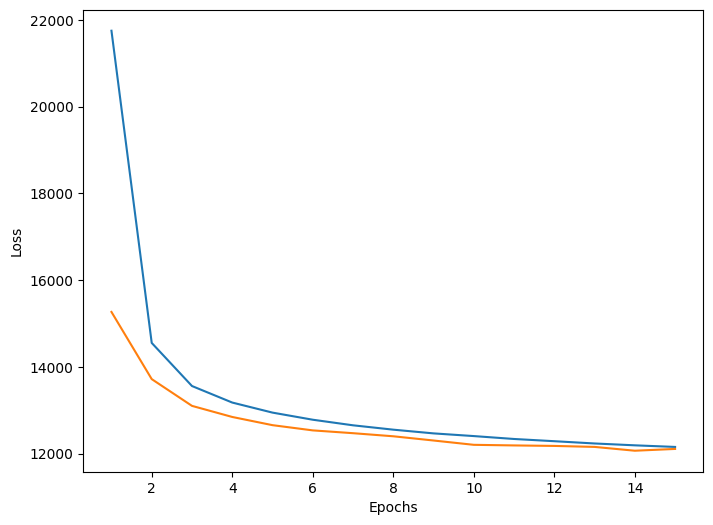

In [19]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(8,6))
plt.plot(epochs, train_losses,label='Train Loss')
plt.plot(epochs,val_losses,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

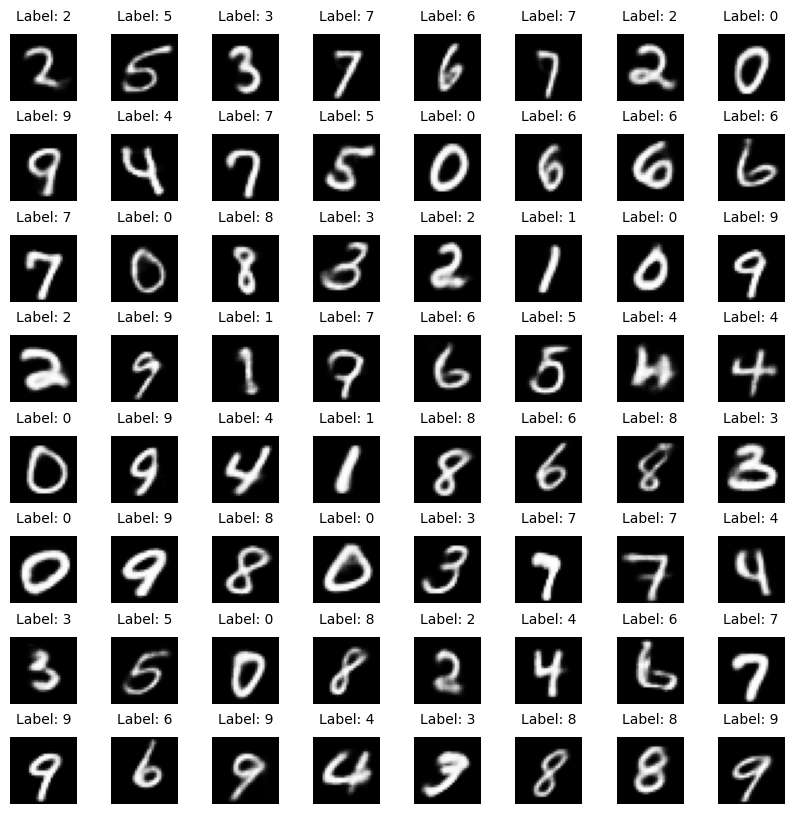

In [20]:
import matplotlib.pyplot as plt

with torch.no_grad():
    num_samples = 64
    labels = torch.randint(0, 10, (num_samples,)).to(device)  # Генерация случайных меток
    generated_images = autoencoder.sample(num_samples, labels)

    generated_images = generated_images.cpu().numpy()

    # Увеличиваем отступы и размер шрифта для подписей
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))  # Увеличили размер сетки
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            axes[i, j].imshow(generated_images[idx].reshape(28, 28), cmap="gray")
            axes[i, j].axis("off")
            # Увеличиваем размер шрифта и делаем отступы
            axes[i, j].set_title(f"Label: {labels[idx].item()}", fontsize=10, pad=10)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Добавляем отступы между изображениями
    plt.show()


In [23]:
# Фильтруем реальные изображения с меткой "1"
real_images, real_labels = next(iter(trainloader))
real_images = real_images[real_labels == 1].to(device)

# Получаем фичи для реальных двоек
real_features = get_features(real_images, lenet)
mu_real, sigma_real = real_features.mean(dim=0), torch.cov(real_features.T)

# Генерируем только двойки
labels = torch.full((num_samples,), 1, device=device)
generated_images = autoencoder.sample(num_samples, labels).to(device)

# Получаем фичи для сгенерированных двоек
gen_features = get_features(generated_images, lenet)
mu_gen, sigma_gen = gen_features.mean(dim=0), torch.cov(gen_features.T)

# Вычисляем FID
fid_value = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print(f"FID для едиинц: {fid_value.item()}")


FID для едиинц: 19.182889938354492
